In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import welch
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.hrv_epatch.io.tdms import load_tdms_from_path
from scipy.signal import butter, filtfilt, iirnotch, welch

## Load dataframe

In [2]:
OUT_DIR = Path(r"E:\Speciale - Results\Datastruct")

df_rec = pd.read_csv(
    OUT_DIR / "recordings_index.csv",
    parse_dates=["recording_start", "recording_end"],
)

df_evt = pd.read_csv(
    OUT_DIR / "seizure_events.csv",
    parse_dates=["absolute_start", "absolute_end"],
)
# Sanity check
print(df_rec.head(), df_evt.head())


# Create copies to avoid unintentional modifications
df_rec_sum = df_rec.copy()
df_evt_sum = df_evt.copy()

   recording_uid  patient_id enrollment_id  recording_id  \
0              0           1           NaN             1   
1              1           1           NaN             2   
2              2           2           NaN             1   
3              3           3           NaN             1   
4              4           3           NaN             2   

                                           tdms_path annotation_source  \
0  E:\ML algoritme tl anfaldsdetektion vha HRV\eP...     patient 1.xls   
1  E:\ML algoritme tl anfaldsdetektion vha HRV\eP...     patient 1.xls   
2  E:\ML algoritme tl anfaldsdetektion vha HRV\eP...     patient 2.xls   
3  E:\ML algoritme tl anfaldsdetektion vha HRV\eP...     patient 3.xls   
4  E:\ML algoritme tl anfaldsdetektion vha HRV\eP...     patient 3.xls   

      recording_start                 recording_end  rec_duration_s     fs  
0 2016-02-22 11:04:14 2016-02-24 16:09:49.750000000   191135.750000  512.0  
1 2016-02-24 16:15:00 2016-02-26 09:00:0

In [3]:
def plot_all_psds(df_rec, outpath):
    """
    Plot PSD of all recordings in a single shared figure.
    Great for spotting recordings with abnormal frequency content.
    """

    outpath = Path(outpath)
    outpath.parent.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(12, 8))

    for _, row in df_rec.iterrows():
        uid = row["recording_uid"]
        tdms = row["tdms_path"]
        fs   = row["fs"]

        # load raw signal
        try:
            sig, _ = load_tdms_from_path(tdms, channel_hint="EKG")
            sig = np.asarray(sig)
            if sig.ndim == 2:
                sig = sig[:, 0]
        except:
            continue

        # welch PSD
        freqs, psd = welch(sig, fs, nperseg=4096)

        plt.semilogy(freqs, psd, alpha=0.35, label=uid)

    plt.title("PSD of all recordings")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power spectral density")
    plt.xlim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def compute_spectral_uniqueness(df_rec):
    """
    Returns a DataFrame with a uniqueness score for each recording,
    based on deviation from the median PSD across all recordings.
    """

    psd_list = []
    freqs = None

    # Step 1: compute PSDs for all
    for _, row in df_rec.iterrows():
        try:
            sig, _ = load_tdms_from_path(row["tdms_path"], channel_hint="EKG")
        except:
            psd_list.append(None)
            continue

        sig = np.asarray(sig)
        if sig.ndim == 2:
            sig = sig[:, 0]

        f, p = welch(sig, row["fs"], nperseg=4096)

        if freqs is None:
            freqs = f
        psd_list.append(p)

    # Step 2: compute median PSD
    psd_array = np.vstack([p for p in psd_list if p is not None])
    median_psd = np.median(psd_array, axis=0)

    # Step 3: compute uniqueness score
    scores = []
    for uid, p in zip(df_rec["recording_uid"], psd_list):
        if p is None:
            scores.append(np.nan)
            continue

        # deviation in log-space
        diff = np.log10(p + 1e-12) - np.log10(median_psd + 1e-12)
        score = float(np.sqrt(np.mean(diff**2)))
        scores.append(score)

    df_unique = pd.DataFrame({
        "recording_uid": df_rec["recording_uid"],
        "spectral_uniqueness_score": scores
    })

    return df_unique

def _preprocess_for_quality(
    sig: np.ndarray,
    fs: float,
    trim_start_s: float = 300.0,   # 5 min
    trim_end_s: float = 300.0,     # 5 min
    bp_low: float = 0.5,
    bp_high: float = 40.0,
    notch_freq: float = 50.0,
    notch_q: float = 30.0,
) -> np.ndarray:
    """
    Trimmer kanter og laver en standard ECG-preprocessing:
    - trimmer de første/sidste X sekunder
    - bandpass 0.5–40 Hz
    - 50 Hz notch

    Bruges KUN til kvalitetsvurdering (ikke til dine egentlige analyser).
    """

    sig = np.asarray(sig).astype(float)
    if sig.ndim == 2:
        sig = sig[:, 0]

    n = sig.size
    if n < 10:
        return sig

    # --- trim start/slut ---
    n_start = int(trim_start_s * fs)
    n_end = int(trim_end_s * fs)

    start_idx = min(n_start, n // 2)  # hvis meget kort, trim maks halvdelen
    end_idx = max(n - n_end, start_idx + 1)

    sig = sig[start_idx:end_idx]

    # --- bandpass 0.5–40 Hz ---
    nyq = fs / 2.0
    low = bp_low / nyq
    high = bp_high / nyq
    if high >= 1.0:
        high = 0.99
    b_bp, a_bp = butter(2, [low, high], btype="band")
    sig = filtfilt(b_bp, a_bp, sig)

    # --- 50 Hz notch ---
    w0 = notch_freq / nyq
    if 0 < w0 < 1:
        b_notch, a_notch = iirnotch(w0, notch_q)
        sig = filtfilt(b_notch, a_notch, sig)

    return sig

def compute_recording_quality(
    df_rec: pd.DataFrame,
    channel_hint: str = "EKG",
    prefer_tz: str = "Europe/Copenhagen",
    window_s: float = 10.0,
    flatline_std_thresh: float = 1.0,
    noise_std_factor: float = 5.0,
    clip_range_thresh: float = 0.9,
) -> pd.DataFrame:
    """
    Recording-level kvalitetsvurdering med:
      - preprocessing (trim + 0.5–40 Hz + 50 Hz notch)
      - vinduesvise STD / range / flatline / noisebursts
      - PSD-baseret QRS-energi vs HF-støj

    Returnerer én række per recording.
    """

    rows = []

    for _, row in tqdm(df_rec.iterrows(), total=len(df_rec)):
        rec_uid = row.get("recording_uid")
        patient_id = int(row["patient_id"])
        recording_id = int(row["recording_id"])
        fs = float(row["fs"])
        tdms_path = Path(row["tdms_path"])

        # ---- load råsignal ----
        try:
            sig_raw, _ = load_tdms_from_path(
                tdms_path, channel_hint=channel_hint, prefer_tz=prefer_tz
            )
        except Exception as e:
            rows.append(
                {
                    "recording_uid": rec_uid,
                    "patient_id": patient_id,
                    "recording_id": recording_id,
                    "load_error": str(e),
                }
            )
            continue

        # ---- preprocess til kvalitetsvurdering ----
        sig = _preprocess_for_quality(sig_raw, fs)
        sig = np.asarray(sig).astype(float)
        if sig.ndim == 2:
            sig = sig[:, 0]

        n = sig.size
        if n < int(window_s * fs):
            rows.append(
                {
                    "recording_uid": rec_uid,
                    "patient_id": patient_id,
                    "recording_id": recording_id,
                    "load_error": "too_short_after_trim",
                }
            )
            continue

        # -------------------------------------------------
        # TIME-DOMAIN window metrics
        # -------------------------------------------------
        win_len = int(window_s * fs)
        n_win = n // win_len
        sig_win = sig[: n_win * win_len].reshape(n_win, win_len)

        std_win = np.std(sig_win, axis=1)
        max_win = np.max(sig_win, axis=1)
        min_win = np.min(sig_win, axis=1)
        range_win = max_win - min_win
        diff_abs_median_win = np.median(np.abs(np.diff(sig_win, axis=1)), axis=1)

        std_med = float(np.median(std_win))
        std_p01 = float(np.percentile(std_win, 1))
        std_p99 = float(np.percentile(std_win, 99))

        range_med = float(np.median(range_win))
        range_p99 = float(np.percentile(range_win, 99))

        diff_med_global = float(np.median(diff_abs_median_win))

        sig_min = float(sig.min())
        sig_max = float(sig.max())
        sig_range = sig_max - sig_min

        frac_flatline = float(np.mean(std_win < flatline_std_thresh))
        frac_noiseburst = float(np.mean(std_win > std_med * noise_std_factor))
        frac_clipping = float(np.mean(range_win > clip_range_thresh * sig_range))

        # -------------------------------------------------
        # FREQUENCY-DOMAIN (på det filtrerede midterstykke)
        # -------------------------------------------------
        # PSD med Welch
        freqs, psd = welch(sig, fs=fs, nperseg=min(4096, n))

        # indbygget bånd: low (0.5–5), QRS (5–25), HF (25–40)
        f = freqs
        p = psd
        total_power = float(np.trapz(p, f) + 1e-12)

        band_low = float(
            np.trapz(p[(f >= 0.5) & (f < 5.0)], f[(f >= 0.5) & (f < 5.0)])
        )
        band_qrs = float(
            np.trapz(p[(f >= 5.0) & (f < 25.0)], f[(f >= 5.0) & (f < 25.0)])
        )
        band_hf = float(
            np.trapz(p[(f >= 25.0) & (f < 40.0)], f[(f >= 25.0) & (f < 40.0)])
        )

        qrs_power_ratio = band_qrs / total_power
        hf_ratio = band_hf / total_power
        lf_ratio = band_low / total_power

        # hvor "spids" er PSD'en?
        psd_kurt = float(
            np.mean((p - np.mean(p)) ** 4) / ((np.std(p) ** 4) + 1e-12)
        )

        rows.append(
            {
                "recording_uid": rec_uid,
                "patient_id": patient_id,
                "recording_id": recording_id,
                "fs": fs,
                "n_samples_used": n,

                # time-domain
                "win_std_median": std_med,
                "win_std_p01": std_p01,
                "win_std_p99": std_p99,
                "win_range_median": range_med,
                "win_range_p99": range_p99,
                "frac_flatline_windows": frac_flatline,
                "frac_noiseburst_windows": frac_noiseburst,
                "frac_clipping_windows": frac_clipping,
                "diff_abs_median_global": diff_med_global,
                "sig_min_proc": sig_min,
                "sig_max_proc": sig_max,
                "sig_range_proc": sig_range,

                # frequency-domain
                "total_power": total_power,
                "band_low": band_low,
                "band_qrs": band_qrs,
                "band_hf": band_hf,
                "qrs_power_ratio": qrs_power_ratio,
                "hf_ratio": hf_ratio,
                "lf_ratio": lf_ratio,
                "psd_kurtosis": psd_kurt,

                "load_error": "",
            }
        )

    return pd.DataFrame(rows)

def classify_recordings(
    df_qual: pd.DataFrame,
    qrs_good_min: float = 0.10,       # før 0.10 — beholdes
    qrs_bad_max: float = 0.05,        # før 0.05 — beholdes
    std_good_min: float = 30.0,       # NY (før 50)
    std_bad_max: float = 20.0,        # NY (før 30)
    std_good_max: float = 800.0,
    flatline_good_max: float = 0.05,
    flatline_bad_min: float = 0.30,
    noise_good_max: float = 0.40,     # øget fra 0.30 → 0.40 (mere realistisk)
    noise_bad_min: float = 0.60
):
    """
    Version 4.1 af recording-level klassifikation.
    - lidt mere tolerant STD-thresholds
    - stadig stringent ift. QRS-power
    """

    labels = []
    reasons = []
    include_flags = []

    for _, r in df_qual.iterrows():
        if r.get("load_error", ""):
            labels.append("bad")
            reasons.append(f"load_error: {r['load_error']}")
            include_flags.append(False)
            continue

        qrs_ratio = r["qrs_power_ratio"]
        std_med = r["win_std_median"]
        frac_flat = r["frac_flatline_windows"]
        frac_noise = r["frac_noiseburst_windows"]

        # ---------- BAD ----------
        if (
            qrs_ratio < qrs_bad_max
            or std_med < std_bad_max
            or frac_flat > flatline_bad_min
            or frac_noise > noise_bad_min
        ):
            labels.append("bad")
            include_flags.append(False)

            reasons_bad = []
            if qrs_ratio < qrs_bad_max:
                reasons_bad.append(f"very low QRS power ({qrs_ratio:.3f})")
            if std_med < std_bad_max:
                reasons_bad.append(f"very low median STD ({std_med:.1f})")
            if frac_flat > flatline_bad_min:
                reasons_bad.append(f"many flatline windows ({frac_flat:.2f})")
            if frac_noise > noise_bad_min:
                reasons_bad.append(f"extreme noise bursts ({frac_noise:.2f})")

            reasons.append("; ".join(reasons_bad))
            continue

        # ---------- GOOD ----------
        if (
            qrs_ratio >= qrs_good_min
            and std_med >= std_good_min
            and std_med <= std_good_max
            and frac_flat <= flatline_good_max
            and frac_noise <= noise_good_max
        ):
            labels.append("good")
            include_flags.append(True)
            reasons.append("clear QRS, acceptable noise")
            continue

        # ---------- BORDERLINE ----------
        labels.append("borderline")
        include_flags.append(False)
        reasons.append("mixed quality, below good thresholds")

    df_out = df_qual.copy()
    df_out["quality_label"] = labels
    df_out["quality_reason"] = reasons
    df_out["include_for_rr"] = include_flags
    return df_out


In [4]:
# 1) Beregn kvalitetsmetrics (preprocesset, trimmede signaler)
df_quality = compute_recording_quality(df_rec)

# 2) Klassificér recordings
df_quality = classify_recordings(df_quality)

  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\4096343355.py:244: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = float(np.trapz(p, f) + 1e-12)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\4096343355.py:247: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(p[(f >= 0.5) & (f < 5.0)], f[(f >= 0.5) & (f < 5.0)])
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\4096343355.py:250: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(p[(f >= 5.0) & (f < 25.0)], f[(f >= 5.0) & (f < 25.0)])
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\4096343355.py:253: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrat

In [5]:
# 3) Se fordeling
df_quality["quality_label"].value_counts()

# 4) Udvælg recording_uid, der skal bruges i videre arbejde
good_recs = df_quality[df_quality["include_for_rr"]]
good_recs[["recording_uid", "patient_id", "recording_id"]]

good_recs.to_csv("good_recordings_for_rr.csv", index=False)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Vælg features, du tror på:
feature_cols = [
    "win_std_median",
    "win_std_p99",
    "frac_noiseburst_windows",
    "frac_flatline_windows",
    "qrs_power_ratio",
    "hf_ratio",
    "lf_ratio",
    "psd_kurtosis",
    # "spectral_uniqueness_score",
]

df_feat = df_quality.dropna(subset=feature_cols).copy()

X = df_feat[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# fx 3 grupper til at starte med
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

df_feat["quality_cluster"] = cluster_labels

# merge tilbage til fulde df, så du også har responder-info etc.
df_quality_clustered = df_quality.merge(
    df_feat[["recording_uid", "quality_cluster"]],
    on="recording_uid",
    how="left",
)


c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


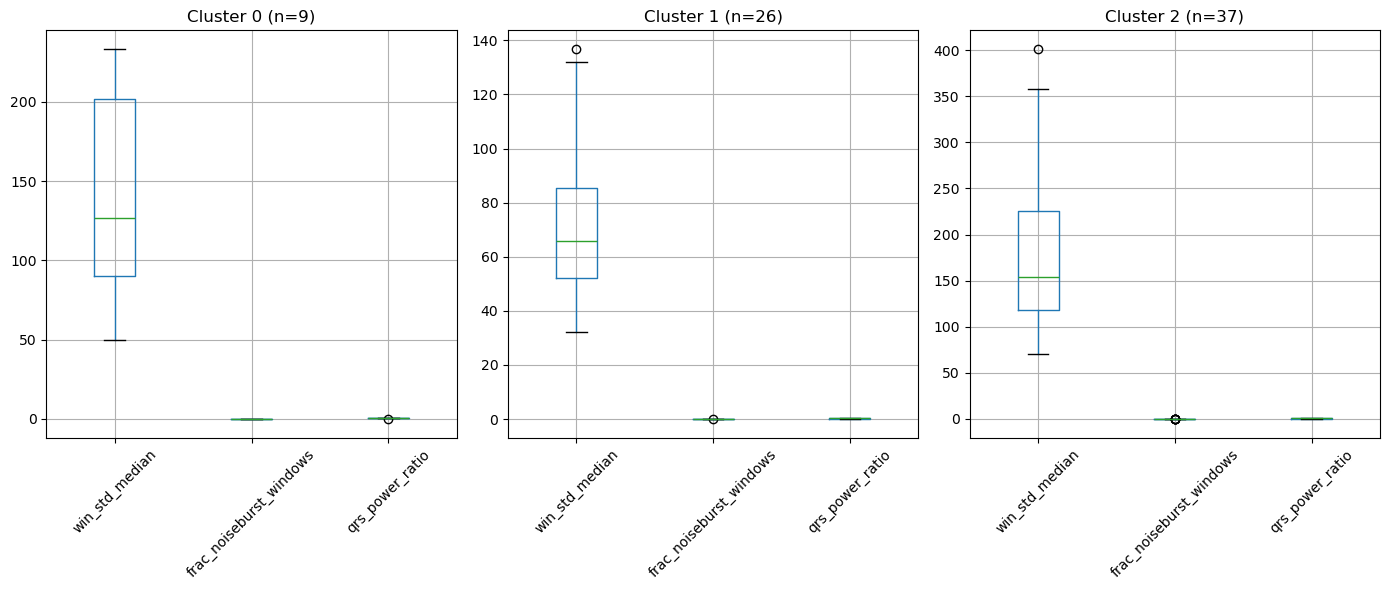

In [7]:
df_quality_clustered.groupby("quality_cluster")[
    ["win_std_median", "frac_noiseburst_windows", "qrs_power_ratio"]
].describe()

df_quality_clustered.to_csv("quality_clusters.csv", index=False)


plt.figure(figsize=(14, 6))
for cluster in sorted(df_quality_clustered["quality_cluster"].unique()):
    plt.subplot(1, 3, cluster + 1)
    cluster_data = df_quality_clustered[df_quality_clustered["quality_cluster"] == cluster]
    cluster_data[["win_std_median", "frac_noiseburst_windows", "qrs_power_ratio"]].boxplot()
    plt.title(f"Cluster {cluster} (n={len(cluster_data)})")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

from src.hrv_epatch.io.tdms import load_tdms_from_path
from scipy.signal import butter, filtfilt, iirnotch, welch

OUT_DIR = Path(r"E:\Speciale - Results\Datastruct")

df_rec = pd.read_csv(OUT_DIR / "recordings_index.csv")
df_evt = pd.read_csv(OUT_DIR / "seizure_events.csv")

# --- genbrug din eksisterende preprocessing fra Study2_1.py ---

def _preprocess_for_quality(sig, fs, trim_start_s=60.0, trim_end_s=60.0,
                            bp_low=0.5, bp_high=40.0, notch_freq=50.0):
    sig = np.asarray(sig).astype(float)
    if sig.ndim == 2:
        sig = sig[:, 0]

    n = sig.size
    if n < 10:
        return sig

    # Trim start/slut (samme logik som i Study2_1)
    n_start = int(trim_start_s * fs)
    n_end = int(trim_end_s * fs)
    start_idx = min(n_start, n // 2)
    end_idx = max(n - n_end, start_idx + 1)
    sig = sig[start_idx:end_idx]

    # Bandpass 0.5–40 Hz
    nyq = fs / 2.0
    low = bp_low / nyq
    high = bp_high / nyq
    if high >= 1.0:
        high = 0.99
    b_bp, a_bp = butter(2, [low, high], btype="band")
    sig = filtfilt(b_bp, a_bp, sig)

    # 50 Hz notch
    w0 = notch_freq / nyq
    if 0 < w0 < 1:
        b_notch, a_notch = iirnotch(w0, Q=30.0)
        sig = filtfilt(b_notch, a_notch, sig)

    return sig


def compute_window_quality_vs_seizure(
    df_rec,
    df_evt,
    channel_hint="EKG",
    prefer_tz="Europe/Copenhagen",
    window_s=10.0,
    flatline_std_thresh=1.0,
    noise_std_factor=5.0,
    clip_range_thresh=0.9,
):
    """
    Beregn vindues-baserede kvalitetsmål og label hver 10 s window
    som 'baseline' eller 'seizure' afhængigt af overlap med annoterede anfald.
    Returnerer én række per window.
    """
    rows = []

    for _, rec in tqdm(df_rec.iterrows(), total=len(df_rec), desc="Window quality"):
        rec_uid = rec["recording_uid"]
        patient_id = int(rec["patient_id"])
        recording_id = int(rec["recording_id"])
        fs = float(rec["fs"])
        tdms_path = Path(rec["tdms_path"])

        # relevant seizures for denne recording
        evt_rec = df_evt[df_evt["recording_uid"] == rec_uid].copy()

        try:
            sig_raw, _ = load_tdms_from_path(
                tdms_path, channel_hint=channel_hint, prefer_tz=prefer_tz
            )
        except Exception as e:
            # hvis der er load-fejl, spring recording over
            continue

        sig = _preprocess_for_quality(sig_raw, fs)
        sig = np.asarray(sig).astype(float)
        if sig.ndim == 2:
            sig = sig[:, 0]

        n = sig.size
        win_len = int(window_s * fs)
        if n < win_len:
            continue

        # opdel i ikke-overlappende vinduer
        n_win = n // win_len
        sig_win = sig[: n_win * win_len].reshape(n_win, win_len)

        # basale features per window
        std_win = np.std(sig_win, axis=1)
        max_win = np.max(sig_win, axis=1)
        min_win = np.min(sig_win, axis=1)
        range_win = max_win - min_win
        diff_abs_med = np.median(np.abs(np.diff(sig_win, axis=1)), axis=1)

        # globale referencer til noise/flatline-def
        std_med = float(np.median(std_win))
        sig_range = float(np.max(sig) - np.min(sig) + 1e-12)

        # thresholds som i compute_recording_quality
        noise_std_thresh = noise_std_factor * std_med

        # tidsskala for vinduer (relativt til trimmede signal)
        # t=0 svarer til start efter trimming, for Study 2 er det nok
        win_starts_s = np.arange(n_win) * window_s
        win_ends_s = win_starts_s + window_s

        # label hver window ift. seizures i evt_rec (t0, t1 i sekunder fra recording-start)
        # her antages, at t0/t1 er relative til recording-start; trimming betyder,
        # at absolute offset kan ignoreres, hvis vi kun bruger relative mønstre.
        # Hvis du vil være helt præcis, kan du korrigere for trim_start_s.
        seizure_intervals = evt_rec[["t0", "t1"]].values if len(evt_rec) > 0 else []

        context_labels = []
        for ws, we in zip(win_starts_s, win_ends_s):
            has_overlap = False
            for t0, t1 in seizure_intervals:
                # overlap hvis midten af vinduet ligger inde i [t0, t1)
                w_mid = 0.5 * (ws + we)
                if (w_mid >= t0) and (w_mid < t1):
                    has_overlap = True
                    break
            context_labels.append("seizure" if has_overlap else "baseline")

        # simple artefakt-flags per window
        is_flat = std_win < flatline_std_thresh
        is_noise = std_win > noise_std_thresh
        is_clip = range_win > (clip_range_thresh * sig_range)

        for i in range(n_win):
            rows.append(
                {
                    "recording_uid": rec_uid,
                    "patient_id": patient_id,
                    "recording_id": recording_id,
                    "window_idx": i,
                    "win_start_s": win_starts_s[i],
                    "win_end_s": win_ends_s[i],
                    "context": context_labels[i],          # baseline vs seizure
                    "std": float(std_win[i]),
                    "range": float(range_win[i]),
                    "diff_abs_med": float(diff_abs_med[i]),
                    "is_flatline": bool(is_flat[i]),
                    "is_noiseburst": bool(is_noise[i]),
                    "is_clipping": bool(is_clip[i]),
                }
            )

    return pd.DataFrame(rows)


df_win = compute_window_quality_vs_seizure(df_rec, df_evt)

# gem til senere resultatanalyse / plots
df_win_out = OUT_DIR / "window_quality_baseline_vs_seizure.csv"
df_win.to_csv(df_win_out, index=False)
df_win_out


Window quality: 100%|██████████| 72/72 [09:55<00:00,  8.26s/it]


WindowsPath('E:/Speciale - Results/Datastruct/window_quality_baseline_vs_seizure.csv')

In [9]:
# globalt sammenligningsplot
df_win.groupby("context")["std"].describe()

# eller pr patient:
df_win.groupby(["patient_id", "context"])["std"].median().unstack("context")


context,baseline,seizure
patient_id,,
1,214.070636,273.905774
2,233.476665,262.989560
3,164.237039,212.733722
4,134.253868,221.065461
5,217.594911,426.991406
6,380.025427,1028.702066
7,163.425606,188.538061
8,120.386556,136.952470
9,144.928275,173.354875


In [11]:
df_win.groupby(["patient_id", "context"])["range"].median()
df_win.groupby(["patient_id", "context"])["is_noiseburst"].mean()

# df_win.groupby(["context"])["hf_ratio"].describe()
# df_win.groupby(["context"])["qrs_power_ratio"].describe()


patient_id  context 
1           baseline    0.001274
            seizure     0.000000
2           baseline    0.001260
            seizure     0.000000
3           baseline    0.000295
                          ...   
41          seizure     0.181818
42          baseline    0.000657
            seizure     0.000000
43          baseline    0.002955
            seizure     0.000000
Name: is_noiseburst, Length: 86, dtype: float64

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# antag df_win er allerede indlæst
# df_win columns: patient_id, context, std, range, is_noiseburst, win_start_s, recording_uid

# --- 1. PATIENT-SPECIFIK SAMMENLIGNING ---

# STD
std_compare = df_win.groupby(["patient_id", "context"])["std"].median().unstack()
range_compare = df_win.groupby(["patient_id", "context"])["range"].median().unstack()
noise_compare = df_win.groupby(["patient_id", "context"])["is_noiseburst"].mean().unstack()

print("Median STD:\n", std_compare)
print("\nMedian Range:\n", range_compare)
print("\nNoiseburst Rate:\n", noise_compare)


# --- 2. GLOBAL FORDELING (baseline vs seizure) ---

global_stats = df_win.groupby("context")[["std", "range", "is_noiseburst"]].agg(
    ["median", "mean", "std", "quantile"]
)

print("\nGlobal stats baseline vs seizure:\n", global_stats)

# Eller med mere eksplicit output
print("\nGlobal STD median:", df_win.groupby("context")["std"].median())
print("Global RANGE median:", df_win.groupby("context")["range"].median())
print("Global NOISEBURST rate:", df_win.groupby("context")["is_noiseburst"].mean())


Median STD:
 context       baseline      seizure
patient_id                         
1           214.070636   273.905774
2           233.476665   262.989560
3           164.237039   212.733722
4           134.253868   221.065461
5           217.594911   426.991406
6           380.025427  1028.702066
7           163.425606   188.538061
8           120.386556   136.952470
9           144.928275   173.354875
10          126.827213   126.107573
11          127.083164   212.022319
12           54.357451    52.655616
13           33.764110    45.043971
14           97.969327   204.230666
15           54.444743    62.203435
16          225.941319   291.267360
17           71.397441    68.834416
18           77.546126   516.077261
19          252.796800   297.747510
20           89.294905   132.696438
21          100.359267   571.614774
22           60.669953   103.983689
23           65.147089    92.311097
24          167.177287   192.682269
25          107.028324   115.896328
26           35

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13972\1486838274.py:23: FutureWarning: Allowing bool dtype in SeriesGroupBy.quantile is deprecated and will raise in a future version, matching the Series/DataFrame behavior. Cast to uint8 dtype before calling quantile instead.
  global_stats = df_win.groupby("context")[["std", "range", "is_noiseburst"]].agg(


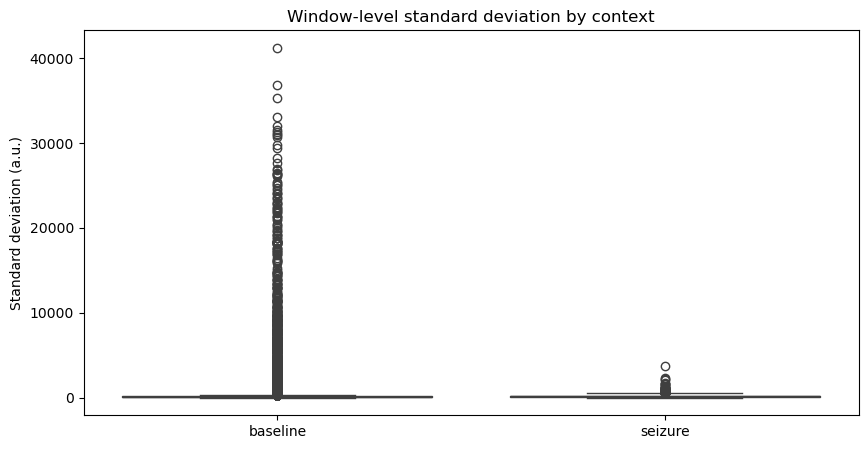

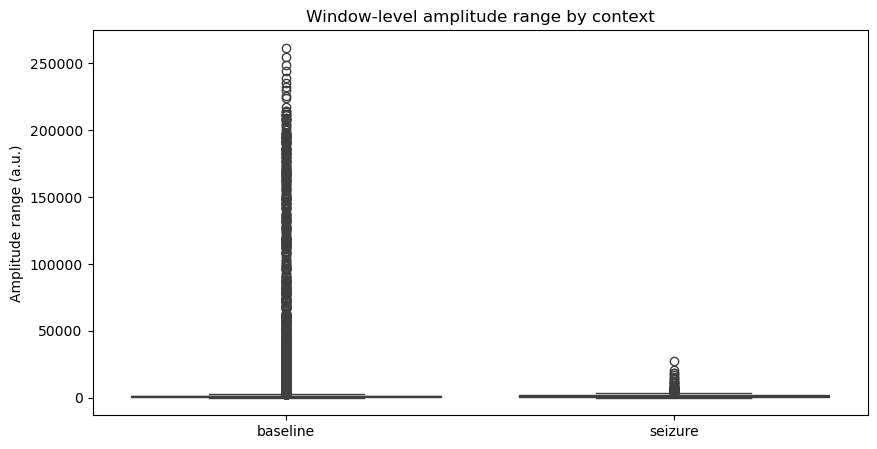

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x="context", y="std", data=df_win)
plt.title("Window-level standard deviation by context")
plt.ylabel("Standard deviation (a.u.)")
plt.xlabel("")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x="context", y="range", data=df_win)
plt.title("Window-level amplitude range by context")
plt.ylabel("Amplitude range (a.u.)")
plt.xlabel("")
plt.show()


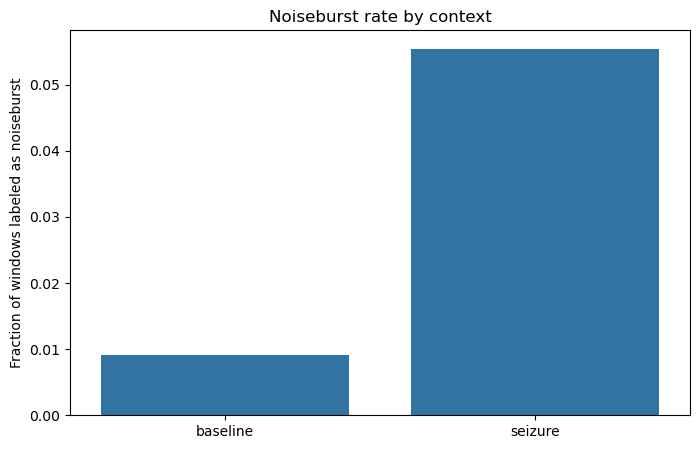

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=["baseline","seizure"],
    y=df_win.groupby("context")["is_noiseburst"].mean().values
)
plt.title("Noiseburst rate by context")
plt.ylabel("Fraction of windows labeled as noiseburst")
plt.show()


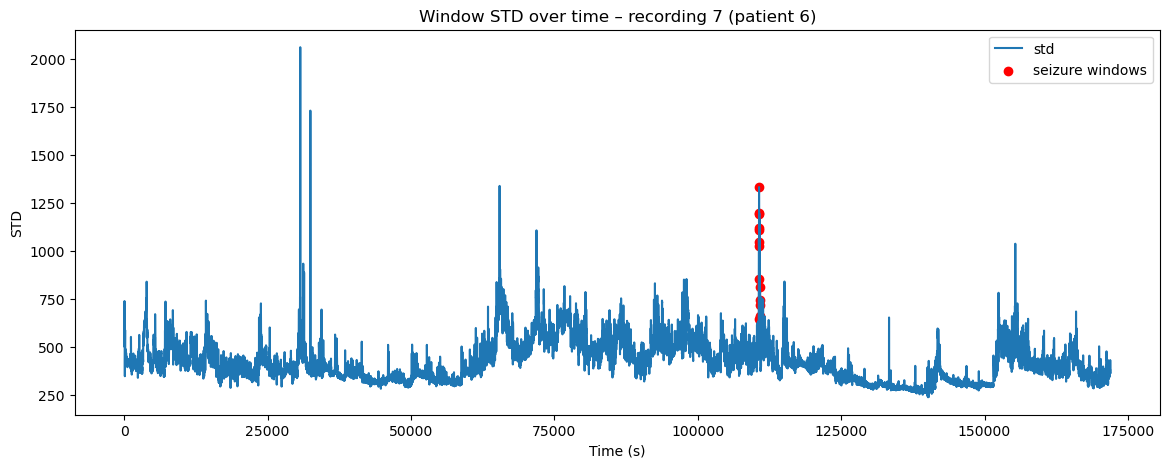

In [17]:
example_patient = 6   # vælg selv
rec_ids = df_win[df_win["patient_id"] == example_patient]["recording_uid"].unique()

for rec in rec_ids[:1]:  # tag første recording for overblik
    df_r = df_win[df_win["recording_uid"] == rec]

    plt.figure(figsize=(14,5))
    plt.plot(df_r["win_start_s"], df_r["std"], label="std")
    plt.scatter(
        df_r[df_r["context"]=="seizure"]["win_start_s"],
        df_r[df_r["context"]=="seizure"]["std"],
        color="red", label="seizure windows"
    )
    plt.title(f"Window STD over time – recording {rec} (patient {example_patient})")
    plt.xlabel("Time (s)")
    plt.ylabel("STD")
    plt.legend()
    plt.show()
